# DQN


### Training of DQN in Tensorflow
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- welcome: 8
- confirm_question: 2
- request: 0
- inform: 1
- not_sure: 10


### slot set

In [3]:
#
slots_set_path = "./parser/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 7
Sample of dict:
- destination1: 0
- taskcomplete: 6
- flightDate2: 1
- travelers: 4
- ticket: 5


### flight dic: info about flights

In [4]:
#
flight_kb_path = "./parser/fkb.json.p"
flight_kb = pickle.load(open(flight_kb_path, 'rb'), encoding="latin")
sample_dict(flight_kb, sample_size=1)

keys = 1000
Sample of dict:
- 995: {'travelers': '3', 'destination1': 'GRU', 'flightDate1': '1', 'flightDate2': '6', 'origin1': 'BOM'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./parser/flight.nl.pairs.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

save_check_point: 20
eva_metric: 2
check_point: 20
model: lstm_tanh
feed_recurrence: 0
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
trained_model_path: None
smooth_eps: 1e-08
pretrained_model_path: None
slot_set: data/slot_set.txt
grad_clip: -0.0001
momentum: 0.1
batch_size: 16
init_rnn: 0
decay_rate: 0.999
cv_fold: 6
max_epochs: 200
slot_rep: 1
sdgtype: rmsprop
activation_func: relu
reg_cost: 0.001
split_method: 1
learning_rate: 0.001
valid_test: 0
hidden_size: 100
dia_slot_val: 2
write_model_dir: .\checkpoints\template\07102016\
act_set: data/dia_acts.txt


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './parser/fg.json.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'diaact': 'request', 'inform_slots': {'travelers': '4', 'destination1': 'MCO', 'flightDate1': '2', 'flightDate2': '3', 'origin1': 'MUC'}, 'request_slots': {}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a flights dictionary for user simulator - slot:possible values

In [10]:
#
flight_dict_path = './parser/dicts.v3.p'
flight_dictionary = pickle.load(open(flight_dict_path, 'rb'), encoding="latin")
samples = sample_dict(flight_dictionary, sample_size=1)

keys = 20
Sample of dict:
- other: ['not available', 'movie assistant number', 'movie booking service', 'search theater', 'cannot book', 'servicing tickets', 'rotten tomatoes', 'pub serves good burgers', 'serves seafood', 'date', 'scary', 'restaurant', 'beer', 'mexican restaurant', 'best restaurant', 'japanese restaurant', "that's odd", 'crossed', 'little late', 'pub', 'number 1', 'switch cities', 'name', 'unable to book movies', 'I cannot understand your reply', 'purchase tickets', 'look up date', 'increased functionality', 'functionality', 'Master User', 'master user', 'two', 'another preference', 'no', 'check again', 'new release', 'new releases', 'place that serves seafood', 'favorite part', 'worth watching', 'subtitiles', 'subtitles', 'many many theaters', 'different selection of movies', 'search for a theater', 'latest showing', 'Italian restaurant', 'restaurant booking service', 'online ticketing', "I can't remember", "can't think of", 'search theaters', 'cheapest', 'do not know

###  Create a User

In [11]:
user = RuleSimulator(flight_dictionary, act_set, slot_set, goal_set, usersim_params)
# user = AlternateSimulator(flight_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [13]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(flight_kb, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(flight_kb, act_set, slot_set, agent_params)

agent.set_nlg_model(nlg_model)

80


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, flight_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 200
# num_episodes = 60

In [16]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [17]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [18]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [19]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(800, status)

warm_start starting ...
Warm_Start 200 epochs, success rate 2.0, ave reward 148.0, ave turns 28.0
Current experience replay buffer size 1400
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 3521
- cur bellman err 20.4383, experience replay pool 3521
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 1 / 800, Success rate: 0 / 1 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -40.0, ave turns 2.0
Train on : 3621
- cur bellman err 20.2859, experience replay pool 3621
Simulation success rate 0.0, Ave reward -40.0, Ave turns 2.0, Best success rate 0
Progress: 2 / 800, Success rate: 0 / 2 Avg reward: -50.00 Avg turns: 22.00
----------------- Episode: 2 ----------------- 
simulation success rate 0.0, ave reward -41.82, ave turns 5.64
Train on : 3903
- cur bellman

simulation success rate 1.0, ave reward 74.34, ave turns 13.32
simulation success rate 1.0, ave reward 74.35, ave turns 13.3
Train on : 665
- cur bellman err 0.2248, experience replay pool 665
Simulation success rate 1.0, Ave reward 74.34, Ave turns 13.32, Best success rate 0
Progress: 23 / 800, Success rate: 11 / 23 Avg reward: 6.96 Avg turns: 22.87
----------------- Episode: 23 ----------------- 
Successful Dialog!
simulation success rate 0.87, ave reward 57.3, ave turns 16.2
simulation success rate 0.81, ave reward 49.19, ave turns 18.02
Train on : 901
- cur bellman err 0.9875, experience replay pool 901
Simulation success rate 0.87, Ave reward 57.3, Ave turns 16.2, Best success rate 0
Progress: 24 / 800, Success rate: 12 / 24 Avg reward: 9.79 Avg turns: 22.42
----------------- Episode: 24 ----------------- 
Successful Dialog!
simulation success rate 0.96, ave reward 69.41, ave turns 13.58
simulation success rate 0.96, ave reward 69.46, ave turns 13.48
Train on : 674
- cur bellman e

simulation success rate 0.41, ave reward -10.21, ave turns 40.82
simulation success rate 0.38, ave reward -13.88, ave turns 40.96
Train on : 2048
- cur bellman err 7.0822, experience replay pool 2048
Simulation success rate 0.41, Ave reward -10.21, Ave turns 40.82, Best success rate 0
Progress: 43 / 800, Success rate: 30 / 43 Avg reward: 34.65 Avg turns: 20.14
----------------- Episode: 43 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.4, ave turns 13.2
simulation success rate 1.0, ave reward 74.45, ave turns 13.1
Train on : 655
- cur bellman err 1.4010, experience replay pool 655
Simulation success rate 1.0, Ave reward 74.4, Ave turns 13.2, Best success rate 0
Progress: 44 / 800, Success rate: 31 / 44 Avg reward: 35.57 Avg turns: 19.95
----------------- Episode: 44 ----------------- 
Successful Dialog!
simulation success rate 1.0, ave reward 74.25, ave turns 13.5
simulation success rate 1.0, ave reward 74.21, ave turns 13.58
Train on : 679
- cur bellm

KeyboardInterrupt: 

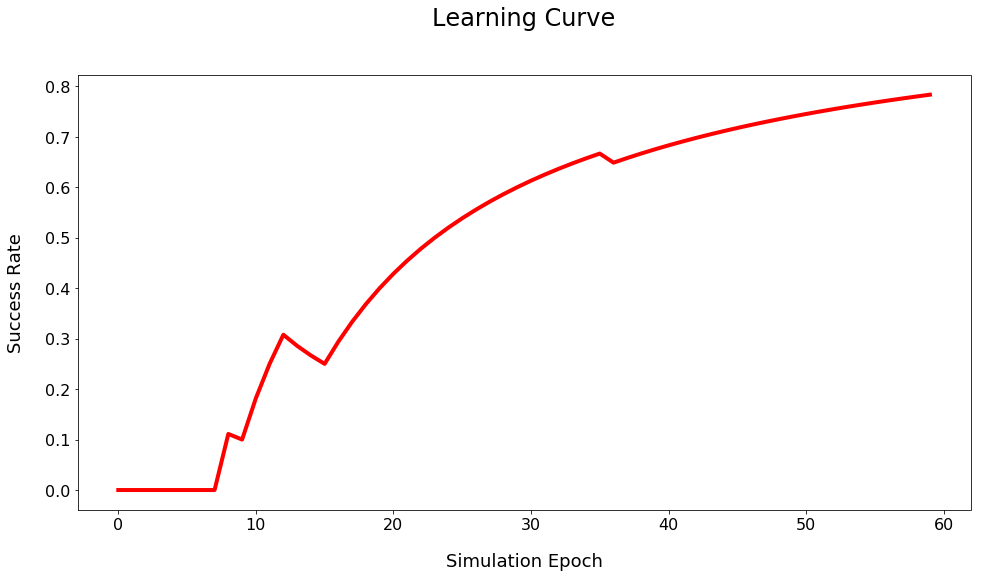

In [20]:
draw_learning_curve(curve)

In [ ]:
draw_loss_curve(losses)

In [ ]:
draw_loss_curve(losses[-100:])

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.save(agent.model.sess, "trained_model/tf_400/", global_step = 400)  